Dependencies

In [7]:
import pandas as pd
import numpy as np
import torch

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm


from io import BytesIO
from PIL import Image

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions

from captum.attr import IntegratedGradients

from preprocessing import smile_to_graph,molgraph_collate_fn
from  edge_memory_network import EMNImplementation

Loading pretrained model

In [8]:
model = EMNImplementation(node_features=16, edge_features=4,edge_embedding_size=25, message_passes=4, out_features=1)
checkpoint = torch.load(r"lightning_logs/version_1/checkpoints/epoch=96.ckpt")
model.load_state_dict(checkpoint['state_dict'])



<All keys matched successfully>

In [9]:
model.eval()

EMNImplementation(
  (embedding_nn): FeedForwardNetwork(in_features=36, hidden_layer_sizes=[150, 150, 150], out_features=25, activation=SELU(), bias=False, dropout_p=0.0)
  (emb_msg_nn): FeedForwardNetwork(in_features=25, hidden_layer_sizes=[80, 80, 80], out_features=25, activation=SELU(), bias=False, dropout_p=0.0)
  (att_msg_nn): FeedForwardNetwork(in_features=25, hidden_layer_sizes=[80, 80, 80], out_features=25, activation=SELU(), bias=False, dropout_p=0.0)
  (gru): GRUCell(25, 25, bias=False)
  (gather): GraphGather(
    (att_nn): FeedForwardNetwork(in_features=50, hidden_layer_sizes=[100, 100, 100], out_features=100, activation=SELU(), bias=False, dropout_p=0.0)
    (emb_nn): FeedForwardNetwork(in_features=25, hidden_layer_sizes=[100, 100, 100], out_features=100, activation=SELU(), bias=False, dropout_p=0.0)
  )
  (out_nn): FeedForwardNetwork(in_features=100, hidden_layer_sizes=[100, 100], out_features=1, activation=SELU(), bias=False, dropout_p=0)
)

Loading Data

In [10]:
data1 = pd.read_csv('sider.csv' )
data_list=[]
        
for index in range(len(data1)):
    adjacency, nodes, edges = smile_to_graph(data1['smiles'][index])
    targets=np.expand_dims(data1['Hepatobiliary disorders'][index], axis=0)
    data_list.append(((adjacency, nodes, edges), targets))


In [11]:

mols = Chem.MolFromSmiles(data1['smiles'][1101] )


Getting attribution scores

In [12]:
 ig = IntegratedGradients(model)
adjacency, nodes, edges, targets=molgraph_collate_fn(np.expand_dims(data_list[1101], axis=0))
attr= ig.attribute(nodes,additional_forward_args= (edges,adjacency),target=0 )


In [13]:
attr1=torch.squeeze(attr, dim=0)
attr2=attr1.sum(dim=1)
vmax = max(attr2.abs().max(), 1e-16)
vmin = -vmax

In [14]:
def get_colors(inp, colormap, vmin=-max(attr1.abs().max(), 1e-16), vmax=max(attr1.abs().max(), 1e-16)):
    norm = plt.Normalize(vmin, vmax)
    return colormap(norm(inp))
node_colors = get_colors(attr2, plt.cm.bwr)
node_colors=node_colors[:,:3]

Drawing molecule

In [15]:
def moltopng(mol,node_colors, edge_colors, molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DCairo(molSize[0],molSize[1])
    drawer.drawOptions().useBWAtomPalette()
    drawer.drawOptions().padding = .2
    drawer.DrawMolecule(
        mc,
        highlightAtoms=[i for i in range(len(node_colors))], 
        highlightAtomColors={i: tuple(c) for i, c in enumerate(node_colors)}, 
        highlightBonds=[i for i in range(len(edge_colors))],
        highlightBondColors={i: tuple(c) for i, c in enumerate(edge_colors)},
        highlightAtomRadii={i: .5 for i in range(len(node_colors))}
    )
    drawer.FinishDrawing()
    return drawer.GetDrawingText()

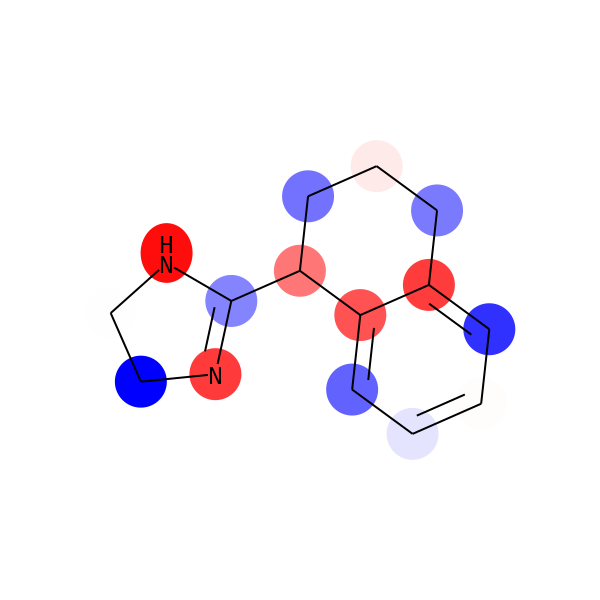

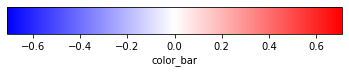

In [16]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = plt.cm.bwr
norm = plt.Normalize(vmin, vmax)

fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='color_bar')


b = BytesIO(); b.write(moltopng(mols, node_colors=node_colors, edge_colors={}, molSize=(600,600))); b.seek(0)
display(Image.open(b))
b.close()

In [17]:
symbols= {i: f'{mols.GetAtomWithIdx(i).GetSymbol()}{i}' for i in range(mols.GetNumAtoms())}

In [18]:
feature_list=[
        'C',
        'N',
        'O',
        'S',
        'F',
        'Si',
        'P',
        'Cl',
        'Br',
        'Unknown',
        'Degree',
        'ImplicitValence',
        'FormalCharge',
        'NumRadicalElectrons',
        'IsAromatic',
        'TotalNumHs']
len(feature_list)

16

Feature Importances
C0 :  0.057
C1 :  -0.383
C2 :  0.375
C3 :  0.468
C4 :  -0.428
C5 :  -0.076
C6 :  0.008
C7 :  -0.566
C8 :  0.530
C9 :  -0.363
C10 :  -0.337
N11 :  0.538
C12 :  -0.711
C13 :  0.003
N14 :  0.664


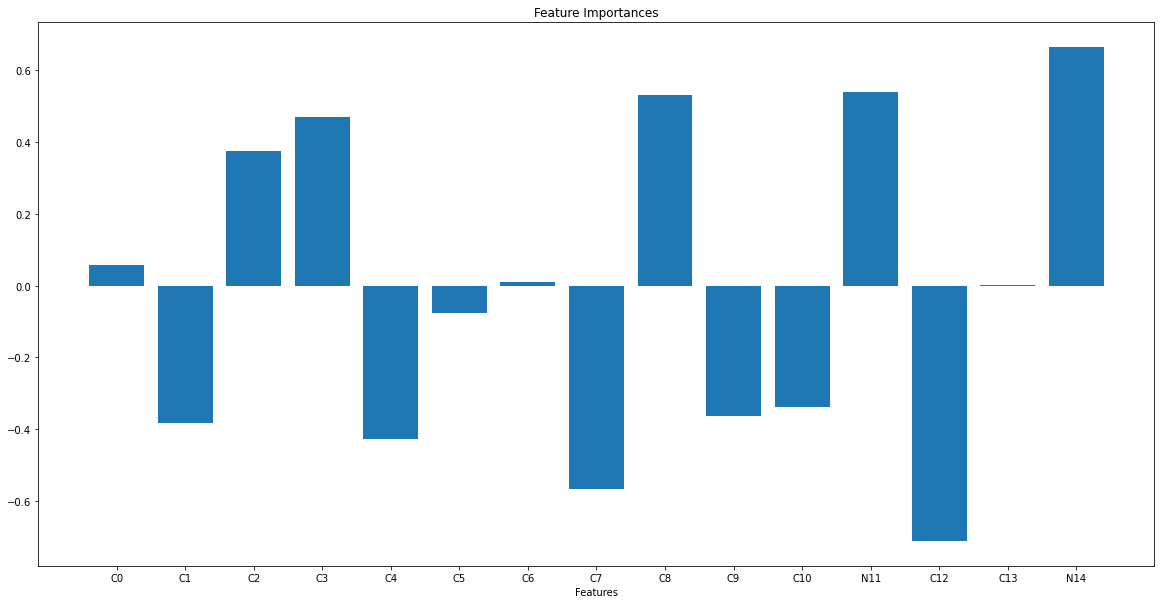

In [19]:

def visualize_importances(feature_names, importances, title="Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(20,10))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names)#,rotation='vertical')
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(list(symbols.values()), attr2)

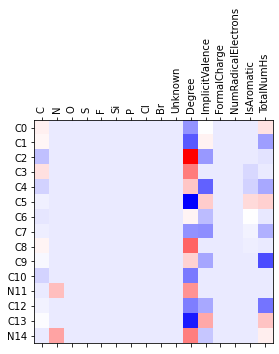

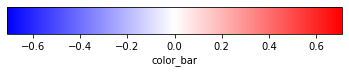

In [20]:
x_pos = (np.arange(len(feature_list)))
y_pos = (np.arange(len(list(symbols.values()))))
plt.matshow(attr1,cmap=cmap)
plt.xticks(x_pos,feature_list,rotation='vertical')
plt.yticks(y_pos,list(symbols.values()))
plt.show()

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='color_bar')
#plt.savefig("matrix_vis.png")